### tsdGAN: A generative adversarial network approach for removing electrocardiographic interference from electromyographic signals 
Lucas Haberkamp<sup>1,2</sup> Charles A. Weisenbach<sup>1</sup> Peter Le<sup>3</sup>  
<sup>1</sup>Naval Medical Research Unit Dayton, Wright-Patterson Air Force Base, OH, USA   
<sup>2</sup>Leidos, Reston, VA, USA   
<sup>3</sup>Air Force Research Laboratory, 711th Human Performance Wing, Wright-Patterson Air Force Base, OH, USA

#### This notebook is used to eliminate ECG interference using template subtraction, as outlined in "Costa et al. (2018): A template subtraction method for reducing electrocardiographic artifacts in EMG signals of low intensity"

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import pickle

Load in synthetic validation dataset

In [26]:
with open('../../Data/Preprocessed Data/Synthetic/Validation/x_val.pkl', 'rb') as f:
  x_val = pickle.load(f)

with open('../../Data/Preprocessed Data/Synthetic/Validation/y_val.pkl', 'rb') as f:
  y_val = pickle.load(f)

with open('../../Data/Preprocessed Data/Synthetic/Validation/label_val.pkl', 'rb') as f:
  label_val = pickle.load(f)

Define hyperparameters and key functions

In [27]:
Fs = 2148

def butterfilter(x, Fc, Fs, type, order=2):
    Wn = np.asarray(Fc)/np.asarray(Fs/2)
    b, a = signal.butter(order, Wn, type)
    return signal.filtfilt(b, a, x)

Main template substraction function

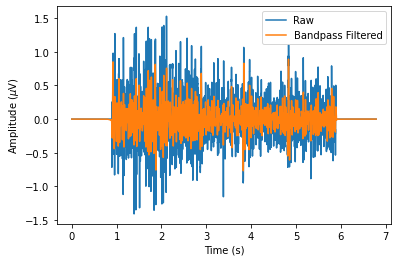

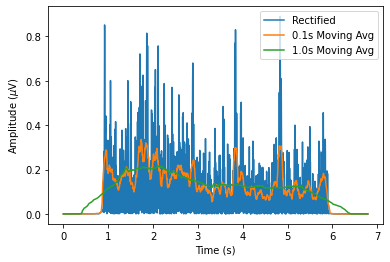

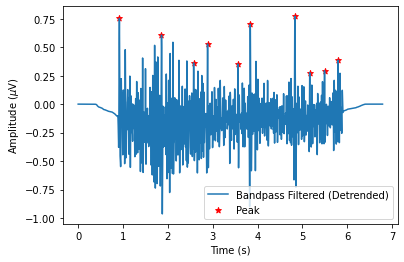

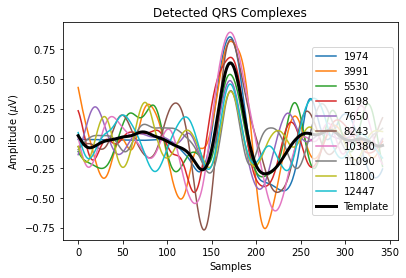

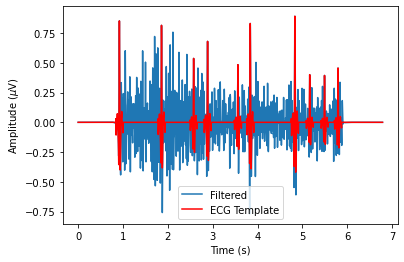

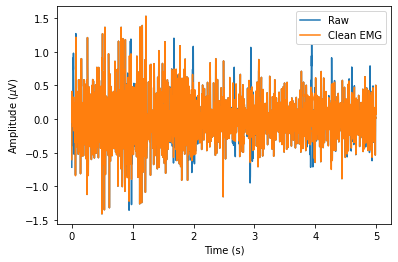

In [28]:
def template_subtraction(raw_data, Fs, plotting=False):

    # QRS window = 0.16 seconds
    qrs_window = int((.16 * Fs) // 2)

    pad_length = 1920

    # Pad the data with zeros to allow template subtraction at ends of the signal
    data = np.hstack([np.zeros(shape=(pad_length,)), raw_data.squeeze(), np.zeros(shape=(pad_length,))])

    # Define the time array
    t = np.arange(len(data))/Fs

    # Bandpass filter between 4 & 50 Hz
    bandpass_filt = butterfilter(data, Fc=[4, 50], Fs=Fs, type='bandpass')

    if plotting:
        plt.plot(t, data, label='Raw')
        plt.plot(t, bandpass_filt, label='Bandpass Filtered')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude ($\mu$V)")
        plt.legend()
        plt.show()

    # Rectify and compute moving averages
    rect = pd.Series(np.abs(bandpass_filt))
    ma1 = rect.rolling(window=int(0.1*Fs), center=True, min_periods=1).mean()
    ma2 = rect.rolling(window=int(1.0*Fs), center=True, min_periods=1).mean()

    if plotting:
        plt.plot(t, rect, label='Rectified')
        plt.plot(t, ma1, label='0.1s Moving Avg')
        plt.plot(t, ma2, label='1.0s Moving Avg')
        plt.ylabel("Amplitude ($\mu$V)")
        plt.xlabel("Time (s)")
        plt.legend()
        plt.show()

    # Find where 0.1s moving average > 1.0s moving average
    potential_peaks = ma1 - ma2
    bandpass_filt_baseline = bandpass_filt - ma2

    # Distance = RR interval for a max heart rate of 220 BPM
    distance = 0.27 * Fs

    # # Use find_peaks on the bandpass filtered signal [Fc = 4-50Hz]
    peaks, _ = signal.find_peaks(bandpass_filt_baseline, height=0, distance=distance) 
    
    # Ensure detected peaks occur where 0.1s moving avg > 1.0s moving avg
    filtered_peaks = []
    for peak in peaks:
        if potential_peaks[peak] >= 0:
            filtered_peaks.append(peak)

    if plotting:
        plt.plot(t, bandpass_filt_baseline, label='Bandpass Filtered (Detrended)')
        plt.scatter(t[filtered_peaks], bandpass_filt_baseline[filtered_peaks], color='r', marker='*', label='Peak')
        plt.ylabel("Amplitude ($\mu$V)")
        plt.xlabel("Time (s)")
        plt.legend()
        plt.show()

    # Obtain all detected QRS complexes
    qrs_template = []
    for peak in filtered_peaks:
        curr_qrs = bandpass_filt[peak-qrs_window:peak+qrs_window+1]
        qrs_template.append(curr_qrs)
        if plotting:
            plt.plot(curr_qrs, label=str(peak))
    # Determine average QRS complex
    qrs_template = np.mean(qrs_template, axis=0)

    if plotting:
        plt.plot(qrs_template, linewidth=3, color='k', label='Template')
        plt.legend(loc='right')
        plt.title("Detected QRS Complexes")
        plt.ylabel("Amplitude ($\mu$V)")
        plt.xlabel("Samples")
        plt.show()

    # Create ECG template. QRS template R peak abcisses must match the bandpass filtered abcisses
    ecg_template = np.zeros(len(data))
    for peak in filtered_peaks:
        adj_qrs_template = qrs_template * (bandpass_filt[peak] / np.max(qrs_template))
        ecg_template[peak-qrs_window:peak+qrs_window+1] = adj_qrs_template

    if plotting:
        plt.plot(t, bandpass_filt, label='Filtered')
        plt.plot(t, ecg_template, color='r', label='ECG Template')
        plt.ylabel("Amplitude ($\mu$V)")
        plt.xlabel("Time (s)")
        plt.legend()
        plt.show()

    # Subtract the ECG template from the raw data and remove the padding
    clean_emg = data - ecg_template
    clean_emg = clean_emg[pad_length:-pad_length]

    if plotting:
        data = data[pad_length:-pad_length]
        new_t = np.arange(len(data))/Fs

        plt.plot(new_t, data, label='Raw')
        plt.plot(new_t, clean_emg, label='Clean EMG')
        plt.ylabel("Amplitude ($\mu$V)")
        plt.xlabel("Time (s)")
        plt.legend()
        plt.show()

    return clean_emg

raw_data = x_val[10][5]
t = np.arange(len(raw_data))/Fs
filtered_data = template_subtraction(raw_data, Fs=Fs, plotting=True)

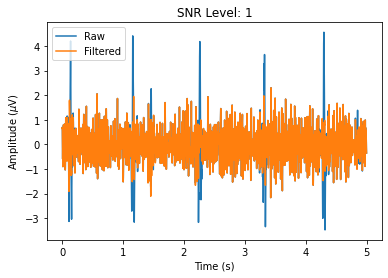

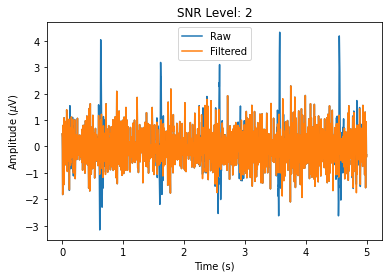

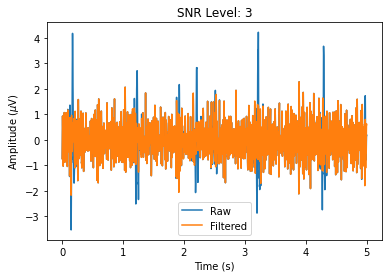

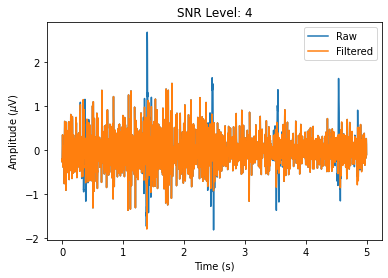

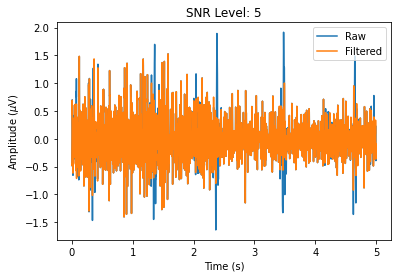

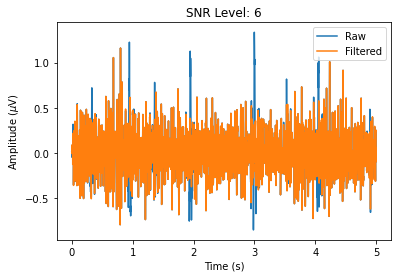

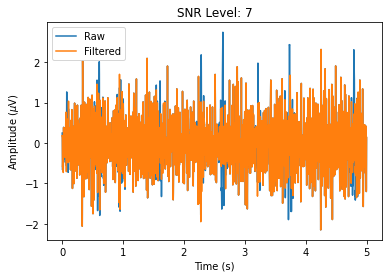

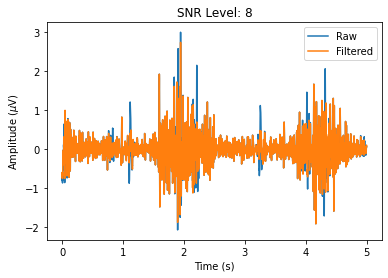

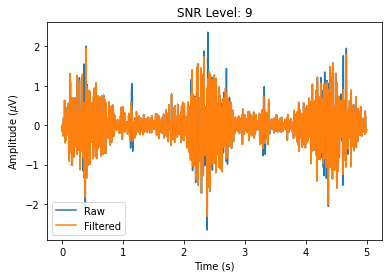

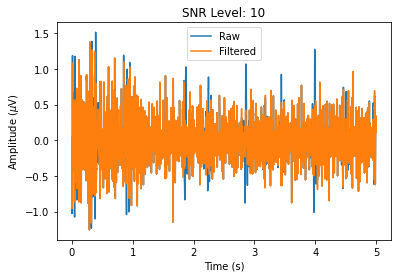

In [29]:
# Define time axis
t = np.arange(len(x_val[1][0]))/Fs

# Apply the template subtraction filter on the validation dataset 
y_pred = {}
for _, key in enumerate(x_val.keys()):
    # Apply the template subtraction method
    y_pred[key] = np.apply_along_axis(template_subtraction, axis=1, arr=x_val[key], Fs=Fs)

    # Generate plot for each SNR level
    plt.plot(t, x_val[key][0], label='Raw')
    plt.plot(t, y_pred[key][0], label='Filtered')
    plt.ylabel("Amplitude ($\mu$V)")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.title(f"SNR Level: {key}")
    plt.show()

In [30]:
# Save the results
with open('../../Data/Synthetic Predictions/TemplateSubtraction.pkl', 'wb') as f:
    pickle.dump(y_pred, f)